# Finding the right model

In [16]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score

from xgboost import XGBClassifier
from xgboost import plot_importance

from imblearn.over_sampling import SMOTE

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
from src.functions import load_OU_data, CourseScaler, plot_confusion, score_grid, \
smotecourses, process_courses, course_cross_validate, Course_GridSearchCV, \
model_evaluate_presentation, cross_val_presentation, GridSearchPresentationCV

import pickle

import warnings

from IPython.display import display

warnings.filterwarnings("ignore")
sns.set_style('white')
pd.set_option('display.max_columns',None)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
df_full = load_OU_data(prediction_window=.75)


In [32]:
df = df_full.copy()
df = df[df['code_module'].isin(['AAA','GGG','BBB'])]
df = df.drop(columns = ['id_student','region','highest_education', \
                   'imd_band','gender','age_band','disability','studied_credits',
                   'module_presentation_length','date_registration'])
df['final_result'] = np.array(['No Intervention' if w in ['Pass','Distinction'] \
              else 'Needs Intervention' for w in df['final_result']])
test_df = df[df['code_presentation'] == '2014J']
test_df = test_df[test_df['code_module'] != 'BBB']

train_df = df[df['code_presentation'] != '2014J']

X_train = train_df.drop(columns = ['final_result','code_presentation'])
y_train = train_df['final_result']
X_test = test_df.drop(columns = ['final_result','code_presentation'])
y_test = test_df['final_result']

X_train_transformed, y_train_transformed, X_test_transformed \
                                = process_courses(X_train, y_train, X_test)

In [19]:
X_train.code_module.value_counts()

BBB    4056
GGG    1642
AAA     321
Name: code_module, dtype: int64

# FSM

In [20]:
modules = X_train.code_module.unique()
scores = pd.DataFrame(index = modules, columns = ['score'])
for module in modules:
    if module in test_df.code_module.unique():
        model = LogisticRegression()
        train = train_df[train_df['code_module'] == module]
        test = test_df[test_df['code_module'] == module]
        X_t = train.drop(columns = ['code_module','final_result', 'code_presentation'])
        y_t = train.final_result
        X_val = test.drop(columns = ['code_module','final_result', 'code_presentation'])
        y_val = test.final_result
        model.fit(X_t,y_t)
        y_pred = model.predict(X_val)
        scores.loc[module,'score'] = accuracy_score(y_val, y_pred)
scores

,score
AAA,0.876623
BBB,0.274858
GGG,0.853736


0.840973116479675

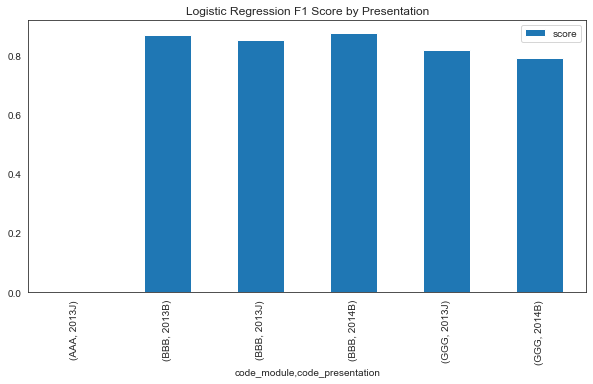

score
code_module code_presentation          
AAA         2013J                   NaN
BBB         2013B              0.868624
            2013J              0.852814
            2014B              0.874236
GGG         2013J              0.817469
            2014B              0.791722

In [21]:
model = LogisticRegression()
scores = cross_val_presentation(model, train_df, scoring = 'f1', verbose = 1)
scores.plot(kind = 'bar', figsize = (10,5), title = 'Logistic Regression F1 Score by Presentation')
plt.show()
display(scores)

## GridsearchCV for best logistic regression hyperparameters

LRparams = [{'solver': ['lbfgs','sag','saga','newton-cg'],
         'penalty': ['none'],
         'random_state':[111]},
          {'solver': ['lbfgs','sag','saga','newton-cg','liblinear'],
         'penalty': ['l2'],
         'random_state':[111]},
          {'solver':['saga'],
          'penalty':['elasticnet'], 'l1_ratio':[.1,.5,.7]},
          {'solver':['saga','liblinear'],
          'penalty':['l1']}]


LRgrid = GridSearchPresentationCV(LogisticRegression(), LRparams,
                                scoring='f1', verbose = 1)

LRgrid.fit(train_df)
LRmodel = score_grid(LRgrid, X_test_transformed, y_test)
pickle.dump(LRmodel,open('../models/LRmodel3.pkl','wb'))

## Logistic Regression Evaluation
By optimizing the hyperparameters of the logistic regression model, which are all regularization parameters, we've barely moved the needle at all.  We gained .0002 accuracy.

# More model types
We used the logistic regression classifier to tune our features, but now it's time to try some other models.  We will use Course_GridsearchCV to optimize the hyperparameters for these as well.

# Decision Tree
A decision tree is a promising candidate for this problem because it does not assume the independence of the features. Instead it seeks to find the best way to divide and subdivide the data in a tree structure based on the values of different variables.  We can tune how many features each split is allowed to consider.  Once the tree is build predictions are made by sending an observations down the tree sending it on a path to the predicted class as it reaches each split in the tree is sent in one or the other direction.  You can think of it like a deterministic Pachinko machine!

DTparams = {'criterion':['gini','entropy'],
           'splitter':['best'],
           'max_depth':[4,10],'min_samples_split':[.01,.1,.2,.5],
           'max_features':[1,2,3,4,5],'random_state':[111]}


DTgrid = GridSearchPresentationCV(DecisionTreeClassifier(), DTparams,
                                scoring='f1', verbose = 1)

DTgrid.fit(train_df)
DTmodel = score_grid(DTgrid, X_test_transformed, y_test)
pickle.dump(DTmodel,open('../models/DTmodel3.pkl','wb'))

### Decision Tree Evaluation 
As expected, this model is better at predicting how a student will do.  It doesn't rely on establishing a straight line through the data to model it, which is probably not the best approach in this problem space.  We see a nice increase in accuracy here.

# Random Forest Classifier
This is an interesting extension to the decision tree model.  It creates a whole forest of decision trees and trains each one on a subset of the data and a subset of the features.  This is a technique called bagging, or [Boostrap AGGregation](https://machinelearningmastery.com/bagging-and-random-forest-ensemble-algorithms-for-machine-learning/) (check the link for more on this).  It works on the principle that a bunch of bad predictors, on average will be more accurate than one good predictor.  This worked for Francis Galton in [guessing the weight of an ox](https://crowdsourcingweek.com/blog/using-the-crowd-to-predict/), maybe it will work here!

RFparams = {'n_estimators':[10,100,150],
           'criterion':['gini','entropy'],
           'max_depth':[4],
           'min_samples_split':[2,4,5],
           'oob_score':[True,False],
           'n_jobs':[-1],'random_state':[111],
           'max_samples':[.5,.7,None]}
           
RFgrid = GridSearchPresentationCV(RandomForestClassifier(), RFparams, scoring = 'f1', verbose = 1)

RFgrid.fit(train_df)

RFmodel = score_grid(RFgrid, X_test_transformed, y_test)
pickle.dump(RFmodel, open('../models/RFmodel3.pkl','wb'))

### Random Forest Classifier Evaluation:
Apparently bagging is not the right approach to this problem.  Our single well tuned decision tree outperformed the random forest classifier.  I guess the wisdom of the crowd is not always superior to the wisdom of the expert!

# eXtreme Gradient Boost model:
XGBoost models have gained a lot of popularity recently and won a lot of Kaggle competitions.  It uses another popular idea called [boosting](https://en.wikipedia.org/wiki/Gradient_boosting).  That's a pretty involved wikipedia article, but the TLDR is that it's a similar ensemble method like random forest, but whereas random forest trains a bunch of trees in parallel and takes the aggregate of their predictions, boosting stacks the trees on top of each other and each one tries to improve on the one below it by predicting where the previous one made mistakes.  I think of it as like a line of morons each grading the next one's paper, which is an analysis of the previous one's paper.  Each one gets a lot wrong, but something right so the right answers percolate through and some of the wrong answers get corrected at each step.

XGBparams = {'n_estimators':[200,300,400],
             'max_depth':[4],
             'learning_rate':[.1], 
             'subsample':[.7],
             'gamma':[1],
             'min_child_weight':[2,4],
             'num_parallel_tree':[2,3],
             'eval_metric':['logloss'],
            'colsample_bytree':[.8,.9,1],
            'base_score':[.4,.5,.6]}
           
XBGgrid = GridSearchPresentationCV(XGBClassifier(objective='binary:logistic', 
                                                 n_jobs=-1, random_state=111),
                                 XGBparams, scoring = 'f1', verbose = 1)
XBGgrid.fit(train_df)

XGBmodel = score_grid(XBGgrid, X_test_transformed, y_test)

pickle.dump(XGBmodel, open('../models/XGBmodel5.pkl','wb'))

plot_importance(XGBmodel, importance_type = 'gain')

## XGBoost evaluation:
XGBoost gave us the best cross-validated score of these four model types.  While it performs slightly worse on the validation set than the random forest, looking at the scores across folds, it seems likely that this represents the validation set being a sort of bad split.  XGBoost also performs equally well on both classes.  It correctly identifies 74% of students who need intervention to succeed, while misclassifying 27% of passing students as needing intervention.  

# SVM
An SVM, or support vector machine, attempts to draw a line, or hyperplane, between the classes to divide them.  This can be degree 2 polynomial line or higher, creating curved dividers of different shapes to match more complex decision boundaries.  It finds the best fit such hyperplane so as to maximize the distance between observations in a recursive manner.  EDA suggests that the observations can, to a large extent, be divided along the variables we have seen.  Decision trees, which do not operate this way, have been relatively successful, but let's see what this model, somewhat more closely related to the logistic regression, can do.

SVCparams = [{'kernel':['linear'],'C':[.01, .1, 1, 10, 100]},
            {'kernel':['poly'],'C':[.01, .1, 1, 10, 100],
             'degree':[3,4]}]
             
SVCgrid = GridSearchPresentationCV(SVC(random_state=111), SVCparams, 
                                scoring='f1', verbose = 1)

SVCgrid.fit(train_df)
SVCmodel = score_grid(SVCgrid, X_test_transformed, y_test)
pickle.dump(SVCmodel, open('../models/SVCmodel2.pkl','wb'))

## SVM Evaluation
The SVM performed quite well.  It scored an overall accuracy of 77% with slight prediction bias toward 'No Intervention', in line with the other models.  

Different hyper parameters didn't make much difference to accuracy, except a polynomial kernel (degree 3) over predicted student success.  This would be the way to go if interventions are particularly costly.  If you biased the predictions that much toward 'No Intervention', you could be fairly certain that the students receiving interventions really need them.  The same results could also be achieved with the logistic regression model by setting the decision point of the sigmoid function toward the passing class, biasing the model.

## K-Nearest Neighbors
This model positions each observation (student registration in this case) from the training set in n_feature dimensional space.  New observations from the test set are voted on by the closest K observations from the training set to determine which class the new observation should belong to. There are two big benefits to this modeling technique for our dataset.  The first is that it is fast with few features.  We have only 6 features, so the dimensionality of the space is low, observations are more tightly packed, and the model makes determinations quickly.  The second benefit is that it is non-linear.  We've had some success with more linear models, and decision tree models.  Our error analysis and EDA show that there are strong linear relationships between our variables and the success of students.  However there is a solid 20% of students that cannot seem to be classified with these linear models.  The decision tree models similar seem to fail to classify these students.  Perhaps this model can help find where they belong.  

KNNparams = {'n_neighbors':[30, 50, 100, 150],
            'weights':['distance', 'uniform'],
             'p':[2,3,4,5,6,7,8,9]}
             
KNNgrid = GridSearchPresentationCV(KNeighborsClassifier(n_jobs = -1), KNNparams, 
                                scoring='f1', verbose = 0)

KNNgrid.fit(train_df)
KNNmodel = score_grid(KNNgrid, X_test_transformed, y_test)
pickle.dump(KNNmodel, open('../models/KNNmodel2.pkl','wb'))

### KNN Evaluation
This model, like the others, seems to top out around 77%.  We still haven't found a way to capture the pattern for how those last 20-23% of students fail or withdraw.  Looking at our error analysis from the final report notebook we see that those misclassfied students really look a lot like successful ones according to all of our variables.  It may just be that we don't have the right variable to find the connection.  We may be running up against the irreducible error for this feature set.

                    precision    recall  f1-score   support

Needs Intervention       0.54      0.86      0.66       248
   No Intervention       0.94      0.73      0.82       689

          accuracy                           0.77       937
         macro avg       0.74      0.80      0.74       937
      weighted avg       0.83      0.77      0.78       937



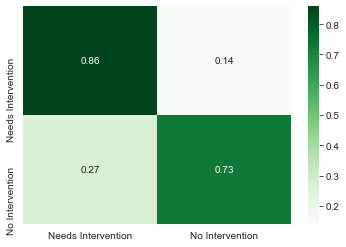

In [33]:
LRmodel = pickle.load(open('../models/LRmodel3.pkl','rb'))
LRmodel.fit(X_train_transformed,y_train_transformed)
y_pred = LRmodel.predict(X_test_transformed)
plot_confusion(y_test, y_pred)
print(classification_report(y_test,y_pred))

                    precision    recall  f1-score   support

Needs Intervention       0.63      0.77      0.69       248
   No Intervention       0.91      0.83      0.87       689

          accuracy                           0.82       937
         macro avg       0.77      0.80      0.78       937
      weighted avg       0.84      0.82      0.82       937



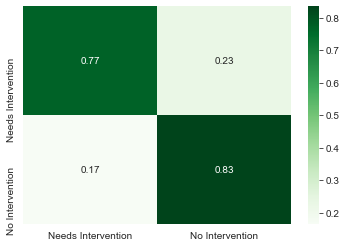

In [34]:
DTmodel = pickle.load(open('../models/DTmodel3.pkl','rb'))
DTmodel.fit(X_train_transformed,y_train_transformed)
y_pred = DTmodel.predict(X_test_transformed)
plot_confusion(y_test, y_pred)
print(classification_report(y_test,y_pred))

                    precision    recall  f1-score   support

Needs Intervention       0.54      0.83      0.65       248
   No Intervention       0.92      0.74      0.82       689

          accuracy                           0.77       937
         macro avg       0.73      0.78      0.74       937
      weighted avg       0.82      0.77      0.78       937



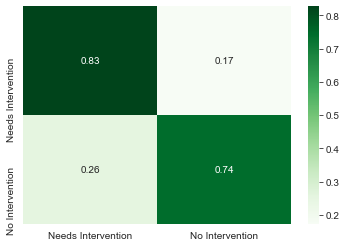

In [35]:
RFmodel = pickle.load(open('../models/RFmodel3.pkl','rb'))
RFmodel.fit(X_train_transformed,y_train_transformed)
y_pred = RFmodel.predict(X_test_transformed)
plot_confusion(y_test, y_pred)
print(classification_report(y_test,y_pred))

                    precision    recall  f1-score   support

Needs Intervention       0.61      0.77      0.68       248
   No Intervention       0.91      0.82      0.86       689

          accuracy                           0.81       937
         macro avg       0.76      0.79      0.77       937
      weighted avg       0.83      0.81      0.81       937



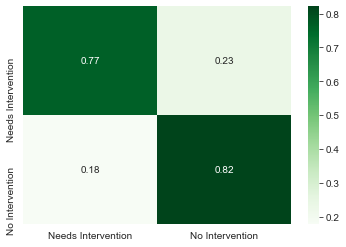

In [36]:
XGBmodel = pickle.load(open('../models/XGBmodel5.pkl','rb'))

XGBmodel.fit(X_train_transformed,y_train_transformed)
y_pred = XGBmodel.predict(X_test_transformed)
plot_confusion(y_test, y_pred)
print(classification_report(y_test,y_pred))

                    precision    recall  f1-score   support

Needs Intervention       0.55      0.85      0.67       248
   No Intervention       0.93      0.75      0.83       689

          accuracy                           0.77       937
         macro avg       0.74      0.80      0.75       937
      weighted avg       0.83      0.77      0.79       937



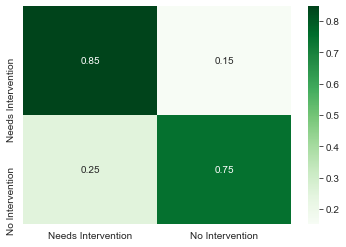

In [38]:
KNNmodel = pickle.load(open('../models/KNNmodel2.pkl','rb'))

KNNmodel.fit(X_train_transformed,y_train_transformed)
y_pred = KNNmodel.predict(X_test_transformed)
plot_confusion(y_test, y_pred)
print(classification_report(y_test,y_pred))

                    precision    recall  f1-score   support

Needs Intervention       0.65      0.61      0.63       248
   No Intervention       0.86      0.88      0.87       689

          accuracy                           0.81       937
         macro avg       0.76      0.74      0.75       937
      weighted avg       0.81      0.81      0.81       937



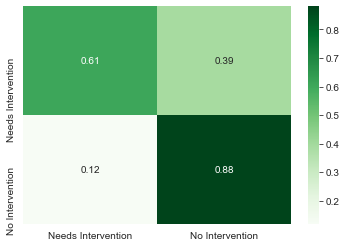

In [37]:
SVCmodel = pickle.load(open('../models/SVCmodel2.pkl','rb'))

SVCmodel.fit(X_train_transformed,y_train_transformed)
y_pred = SVCmodel.predict(X_test_transformed)
plot_confusion(y_test, y_pred)
print(classification_report(y_test,y_pred))

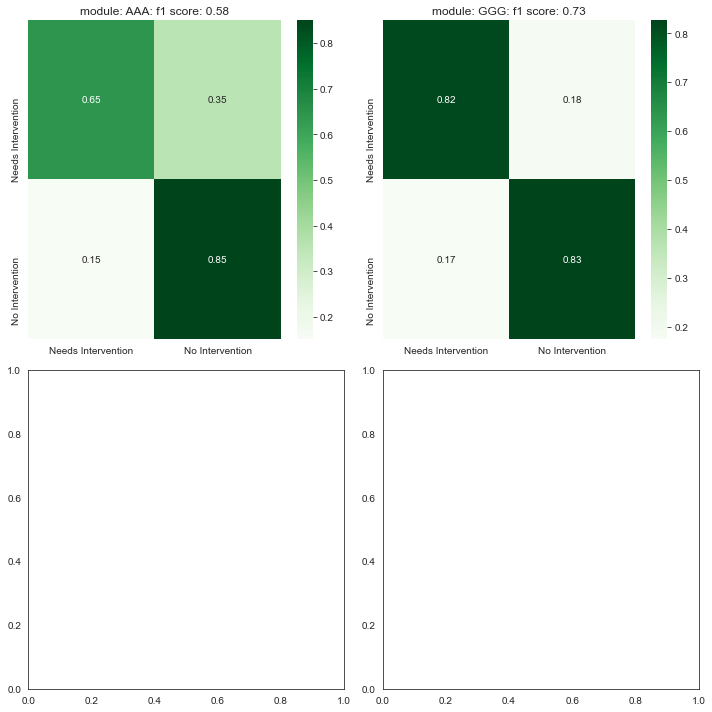

In [40]:
best_model = pickle.load(open('../models/DTmodel3.pkl','rb'))
best_model.fit(X_train_transformed,y_train_transformed)
y_pred = best_model.predict(X_test_transformed)
eval_df = test_df
eval_df['prediction'] = y_pred
modules = eval_df['code_module'].unique()
course_acc = pd.DataFrame(columns = ['score'],index = modules)
fig, axes = plt.subplots(2,2, figsize = (10,10))
axes = axes.ravel()
for i, module in enumerate(modules):
    preds = eval_df[eval_df['code_module'] == module]['prediction']
    trues = eval_df[eval_df['code_module'] == module]['final_result']
    accuracy = f1_score(trues,preds, pos_label='Needs Intervention')
    course_acc.loc[module,'score'] = accuracy
    plot_confusion(trues,preds, ax = axes[i])
    axes[i].set_title(f'module: {module}: f1 score: {round(accuracy,2)}')
plt.tight_layout()
plt.show()

In [29]:
module

'GGG'

In [30]:
df[df['code_module'] == 'BBB'].groupby(by = 'code_presentation').mean()

,num_of_prev_attempts,days_studied,activities_engaged,total_clicks,assessments_completed,average_assessment_score
code_presentation,,,,,,
2013B,0.252705,46.129057,238.231839,784.312983,6.872488,71.176794
2013J,0.191713,41.768089,203.798392,632.331478,7.094620,73.085676
2014B,0.241921,38.095197,185.078603,571.986026,7.053275,72.941031
2014J,0.154528,37.668778,202.976567,765.530716,3.550982,62.548944


In [31]:
df.loc[df['code_module'] == 'BBB', 'final_result'].value_counts()

No Intervention       3713
Needs Intervention    1922
Name: final_result, dtype: int64